# Coursework 2
## MTH739P: Topics in Scientific Computing
### Gerardo Duran Martín

In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Einsum
using TensorOperations
using StatsPlots
using Statistics

In [3]:
default(size=(600, 300))
new = [CartesianIndex()];

## Question 1: pseudospectral methods

### a) Evaluation of a first derivative

Write a program that numerically evaluates the first derivative using pseudo-spectral methods of a function $f(x)$ evaluated a set of grid of points  $\left\{x_n = \frac{a + b}{2} + \frac{a - b}{2}\cos\theta_n\right\}_{n=0}^N$; where $a, b$ are the limits of the evaluation interval, $\theta_n = n\pi / N$. Evaluate the derivatives using the approximation

$$
    f'(x_n) = \sum_{m=0}^N D_{nm}f(x_m)
$$

Where $D_{nm}$ are the elements of the $(N+1)\times(N+1)$ Chebyshev derivative matrix given by

$$
    {\bf D}_{00} = -\frac{2N^2 + 1}{3(b-a)}
$$


$$
    {\bf D}_{nn} = \frac{\cos\theta_n}{(b-a) \sin^2\theta_n}
$$

$$
    {\bf D}_{NN} = \frac{2N^2+1}{3(b-a)}
$$


$$
    {\bf D}_{nm} = \frac{2 c_n (-1)^{n + m}}{(b-a) c_m (\cos \theta_m - \cos\theta_n)}
$$

With $c_n = 1 + \mathbb{1}(n=0) + \mathbb{1}(n=N)$

In [8]:
c(n, N) = 1 + (n == 0) + (n == N)


"""
Evaluate an entry of the chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

# Arguments
- `a::Integer`: Initial value
- `b::Integer`: Final value
- `n::Integer`: row of the matrix
- `m::Integer`: column of the matrix
- `N::Integer`: Lenght of the matrix - 1


# Returns
- `::Array`: (N+1) × (N+1) chebyshev matrix
"""
function D_entry_chebyshev(a, b, n, m, N)
    n, m = n - 1, m - 1
    θn = n * pi / N
    θm = m * pi / N
    
    if n == 0 && m == 0
        D = -(2N ^ 2 + 1) / 3(b - a)
    elseif n == N && m == N
        D = (2N ^ 2 + 1) / 3(b - a)
    elseif n == m
        D = cos(θn) / ((b - a) * sin(θn) ^ 2)
    else
        D = 2c(n, N) * (-1) ^ (n + m) / ((b - a) * c(m, N) * (cos(θm) - cos(θn)))
    end
    
    return D
end


"""
Create a Chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

# Arguments
- `a::Integer`: Lower bound of evaluation
- `b::Integer`: Upper bound of evaluation
- `N::Integer`: Number of gridpoints to evaluate (+1)

# Returns
- `::Array`: (N+1, N+1) matrix with Chebyshev colocation points
"""
function D_chebyshev(a, b, N)
    D = zeros(N + 1, N + 1)
    for n=1:N+1
        for m=1:N+1
            D[n, m] = D_entry_chebyshev(a, b, n, m, N)
        end
    end
    
    return D
end


"""
Create a grid point of N+1 values from
a to b to be used in the Chebyshev pseudospectral method

# Arguments
- `a::Integer`: Lower evaluation bound
- `b::Integer`: Upper evaluation bound
- `N::Integer`: Total number of evaluation points (+1)

# Returns
- `::Array{Float64,1}`: Evaluation points
"""
function range_chebyshev(a, b; length)
    θvals = (0:length) .* pi / length
    xvals = (a + b) / 2. .+ (a - b) / 2. .* cos.(θvals)
    
    return xvals
end


"""
Evaluate the derivative of a function f:R->R using a
pseudo-spectral method using a Chebyshev

# 
"""
function DChebyshev(f, a, b, N)
    xrange = range_chebyshev(a, b, length=N)
    D = D_chebyshev(a, b, N)
    # For stability and accuracy purposes, we replace each element
    # of the main diagonal with the negative sum of all matrix elements
    # in the same row
    D[diagind(D)] = -sum(D .* (ones(N+1, N+1) - I), dims=2)
    df_values = D * f.(xrange)
    
    return xrange, df_values
end


"""
# Build a differentiation matrix

This function builds a differentiation matrix required to compute
a second-order finite-differences method assuming equidistant points

# Arguments
- `x_grid::StepRangeLen`: Points at which to evaluate the derivative
- `Δx::Float`: Step size
"""
function build_diff_matrix(x_grid, Δx)
    n_grid = length(x_grid)
    D = zeros(n_grid, n_grid)
    
    for row in 1:n_grid
        if row == 1
            # Left-difference formula
            D[row, row] = -3
            D[row, row + 1] = 4
            D[row, row + 2] = -1
        elseif row == n_grid
            # Right-difference formula
            D[row, row - 2] = 1
            D[row, row - 1] = -4
            D[row, row] = 3
        else
            # Central-difference formula
            D[row, row - 1] = -1
            D[row, row] = 0
            D[row, row + 1] = 1
        end
    end
    
    D = D ./ 2Δx
    return D
end

build_diff_matrix

In [141]:
f(x) = exp(-x^2)
df(x) = -2x * exp(-x^2)

df (generic function with 1 method)

### b) Numerical error

In this section we approximate the derivative of a function $f$ and compare it against its analytical solution by plotting the difference
    
$$
    \frac{d}{dx}f_\texttt{numerical}(x) - \frac{d}{dx}f_\texttt{analytical}(x)
$$

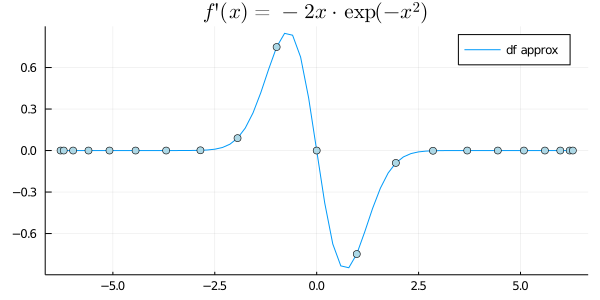

In [142]:
a, b = -2pi, 2pi
N = 100
xrange, df_approx = DChebyshev(f, a, b, N)
plot(xrange, df_approx, label="df approx", title=L"f'(x) = -2x \cdot \exp(-x^2)")
plot!(xrange[begin:5:end], df_approx[begin:5:end], marker=true, linewidth=0, label=nothing, color="lightBlue")

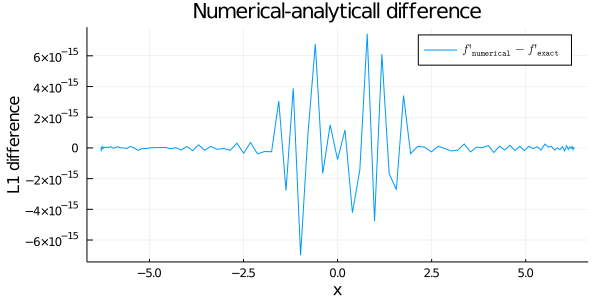

In [143]:
plot(xrange, df.(xrange) - df_approx, ylabel="L1 difference", xlabel="x",
     title="Numerical-analyticall difference", label=L"f'_\texttt{numerical} - f'_\texttt{exact}")

### c) L1 error norm

In this section we show that the difference between our numerical derivatives and the known analytical ones approaches zero. 

You might do this by graphing $\exp(N)\ell_1 \sim C$ or $\log\ell_1 \sim C - N$ for several values of $N$, where $\ell_1 = \sum_{n=0}^N |f'_\texttt{numerical}(x_n) - f'_\texttt{analytical}(x_n)|$

In [144]:
Nmax = 110

Nrange = 1:1:Nmax
l1_values = zeros(length(Nrange))
for (i, N) in enumerate(Nrange)
    xrange, df_approx = DChebyshev(f, a, b, N)
    l1 = sum(abs.(df.(xrange) - df_approx))
    l1_values[i] = l1
end

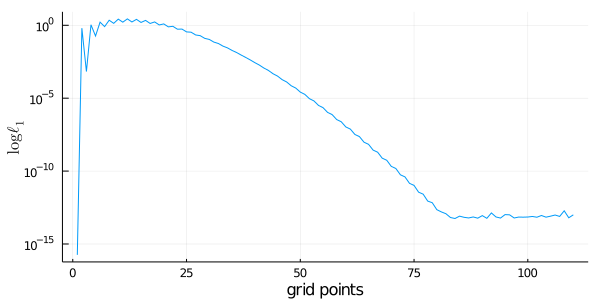

In [145]:
plot(Nrange, l1_values, label=nothing, xlabel="grid points", ylabel=L"\log\ell_1", yaxis=:log)

## Question 2: ODE Integration

Consider the pendulum described by the first-order system

$$
\begin{align*}
\frac{dq}{dt} &= p\\
\frac{dp}{dt} &= f(q)\\
\end{align*}
$$

Where $f(q) = -V'(q) = -\sin(q)$; $V(q) = 1 - \cos(q)$

In [146]:
f(q) = -sin(q)
V(q) = 1 - cos(q)

V (generic function with 1 method)

### Using Runge-Kutta 2

In [147]:
"""
Implementation of a second-order Runge-Kutta ODE
solver

# Arguments
fs: Tuple
    Collection of m functions for the ode
    ẋ = f(x)
initial_conditions: Array
    Collection of m initial conditions
Δt: float
    Timestep size
T: float / int
    Time of integration

Returns
-------
Array of size (T / Δt + 1, m) of the integration
the system from 0 to T
"""
function rk2(fs, initial_conditions, Δt, T)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        k1 = Δt .* [f(yn...) for f in fs]
        k2 = Δt .* [f(yn + k1 / 2...) for f in fs]
        yn = yn + k2
        hist[ti, :] = yn
    end
    
    return hist
end

rk2

In [148]:
vmin, vmax = -2pi, 2pi

xs = vmin:pi/3:vmax
ys = vmin:pi/3:vmax

df(x, y) = [y, -sin(x)] ./ 3.5

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys];

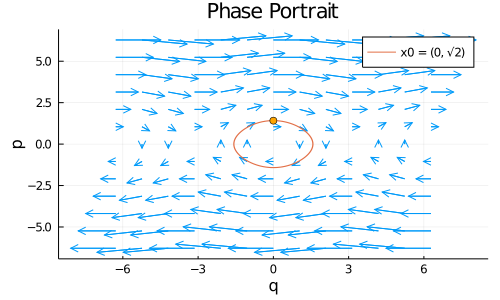

In [149]:
T = 100
dt = 0.1
system = ((q, p) -> p, (q, p) -> f(q))
cond0 = [0, sqrt(2)]
qp_hist = rk2(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

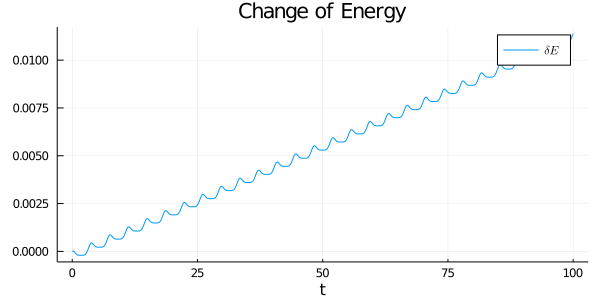

In [150]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

### Using the Trapezium rule

$$
\begin{align*}
    q(t_{n+1}) - q(t_n) &\approx \frac{\Delta t}{2}[p(t_{n+1} + p_{t_n})]\\
    p(t_{n+1}) - p(t_n) &\approx \frac{\Delta t}{2}\left[f\big(q(t_{n+1})\big) + f\big(q(t_n)\big)\right]\\
\end{align*}
$$

In [151]:
function trapezoidal(fs, initial_conditions, Δt, T, inner_it=10)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        # RK2 as initial guess
        y_old = rk2(fs, yn, dt, dt)[end, :]
        for _ in 1:inner_it
            y_new = yn + Δt / 2 .* [f(y_old...) + f(yn...) for f in fs]
            y_old = y_new
        end
        yn = y_old
        hist[ti, :] = yn
    end
    
    return hist
end

trapezoidal (generic function with 2 methods)

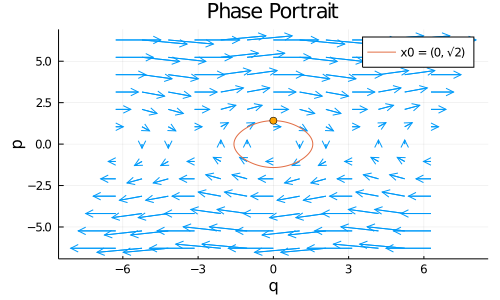

In [152]:
qp_hist = trapezoidal(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

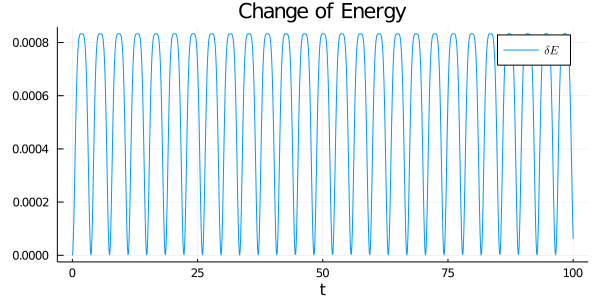

In [153]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

## Question 3: PDE Integration

$$
\partial_t^2 u - c^2 \partial_x^2 u = 0
$$

First note that if $c=1$, the solution $u_\texttt{analytical}(x) = f(t - x)$ satisfies the wave equation:

$$
\begin{align*}
    \partial_t^2 u - c^2 \partial_x^2 &= f''(t-x) - c^2 f''(t - x)\\
    &= f''(t-x) - f''(t - x)\\
    &= 0
\end{align*}
$$

Denoting $\pi = \partial_t u$, we rewrite the wave equation as follows

$$
\begin{align*}
    \dot u &= \pi\\
    \dot\pi &= c^2\partial_x^2 u
\end{align*}
$$

### b) Solving the wave equation (Runge Kutta)

In this section, we write a program that uses the method of lines to evolve the first-order reduced waved equation.

In [4]:
f(x) = exp(-16x^2)
df(x) = -32x * exp(-16x^2)

df (generic function with 1 method)

In [5]:
u_analytical(t, x) = f(x - t)

u_analytical (generic function with 1 method)

In [24]:
N = 301
a, b = -3, 3
D = D_chebyshev(a, b, N)
D2 = D ^ 2
D2[[begin, end], :] .= 0
xrange = range_chebyshev(a, b, length=N);

In [25]:
# A memory-inefficient way to solve it
O = zeros(N + 1, N + 1)
L = [O  I; 
     D2 O];

Since $\pi = \partial_t u = \dot u$, and $\dot u(0, x) = -c f'(x)$ we obtain our initial conditions:

$$
\begin{align*}
    \pi(0, x) &= -c f'(x)\\
    u(0, x) &= f(x)
\end{align*}
$$

In [26]:
Δt = 5e-5
T = 0.5
nits = Int(ceil(T / Δt + 1))

Un = [f.(xrange); -df.(xrange)]
U_hist = zeros(nits, 2N + 2)
U_hist[begin, :] = Un

for ti in 2:nits
    U_slack_1 = Un + Δt * L * Un
    U_slack_2 = (3Un + U_slack_1 + Δt * L * U_slack_1) / 4.
    Un = (Un + 2 * U_slack_2 + 2Δt * L * U_slack_2) / 3.
    U_hist[ti, :] = Un
end

U_hist = reshape(U_hist, (nits, N + 1, 2));

In [27]:
t_eval = 0:Δt:T
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_numerical = U_hist[:, :, 1]
u_error = u_eval - u_numerical;

In [28]:
u_map = abs.(u_error)
min_error = minimum(u_map)
max_error = maximum(u_map)
u_map = (u_map .- min_error) / (max_error - min_error);

In [29]:
sum(u_error[:, end])

9.272982431150799e-42

In [30]:
println("minimum error: $min_error")
println("maximum error: $max_error")

minimum error: 0.0
maximum error: 7.892575482060238e-12


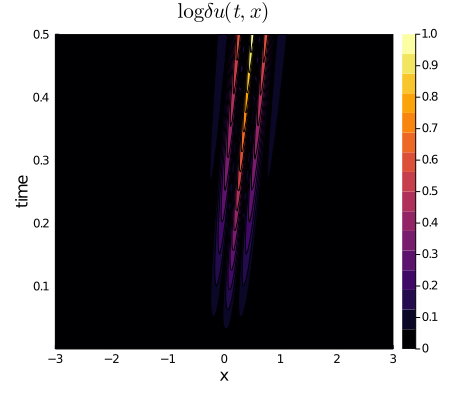

In [31]:
contourf(xrange, t_eval[2:end], u_map[2:end, :], 
    xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400))

In [23]:
nframes = 15
nskip = Int(floor(nits / nframes))

666

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
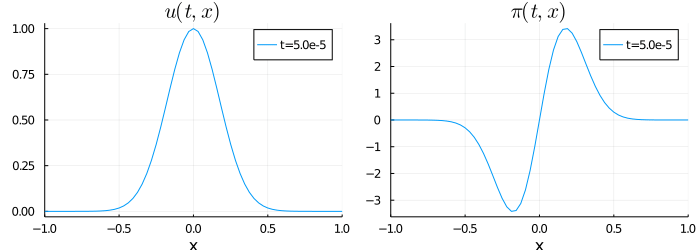

In [572]:
@gif for i in 1:nits
    time = round(Δt * i, digits=5)
    p1 = plot(xrange, U_hist[i, :, 1], label="t=$time", title=L"u(t, x)", xlabel="x", xlim=(-1,1))
    p2 = plot(xrange, U_hist[i, :, 2], label="t=$time", title=L"\pi(t,x)", xlabel="x", xlim=(-1, 1))
    plot(p1, p2, layout=(1, 2), size=(700, 250), suptitle="df")
end every nskip

### c) Plotting the energy

The total energy of the system at time $t$ is given by

$$
\begin{align*}
        E(t) = \frac{1}{2}\int \big[ (\partial_t u)^2 + c^2 (\partial_x u)^2 \big] dx
\end{align*}
$$

Recalling that $c=1$, we compute the energy of the system from -1 to 1 as follows

$$
\begin{align*}
        E(t) &= \frac{1}{2}\int (\partial_t u)^2 dx + \frac{1}{2}\int (\partial_x u)^2 dx\\
        &\approx \frac{1}{2}\int \pi(t, x) ^ 2 dx + \frac{1}{2}\int \mathbb{D}{\bf u}(t, x) dx \\
        &\approx \frac{1}{2}{\bf w}^T \boldsymbol{\pi}^2(t) + \frac{1}{2}{\bf w}^T (\mathbb{D}{\bf u}(t))^2\\
        &= \frac{1}{2}{\bf w}^T\left[ \boldsymbol{\pi}^2(t) + (\mathbb{D}{\bf u}(t))^2 \right]
\end{align*}
$$

Where ${\bf w}$ is a vector of weights necessary to compute the integral from -1 to 1 using the Clenshaw-Curtis quadrature rule which is given by

$$
    w_n = \begin{cases}
    1 / N ^2 & n \in \{0, N\} \\
    \frac{2}{N}\left(1 - \sum_{k=1}^{(N-1)/2}\frac{2\cos(2k\theta_n)}{4k^2-1}\right) & n\in\{1, \ldots, N-1\}
    \end{cases}
$$

In [32]:
pi_numerical = U_hist[:, :, 2];

In [33]:
length(pi_numerical)

3020302

In [52]:
"""
Compute the clenshaw-curtis weights to integrate a
function f from a to b taking N (+1) steps

# Arguments
- `N::Integer`: Total number of steps - 1
"""
function clenshaw_curtis_weights(N, a=-1, b=1)
    weights = zeros(N + 1)
    theta_N = (0:N) .* pi / N
    for (n, theta_n) in zip(0:N, theta_N)
        if n == 0 || n == N
            w = 1 / N ^ 2
        else
            w = 2 / N * (1 - sum(2cos(2k * theta_n) / (4k^2 - 1) for k=1:((N-1)/2)))
        end
        
        weights[n+1] = w * (b - a) / 2
    end
    return weights
end

clenshaw_curtis_weights

In [53]:
w_cc = clenshaw_curtis_weights(N, a, b);

In [54]:
dot(f.(xrange), w_cc) - 0.4431134627263790068245418708352

-5.551115123125783e-17

In [55]:
@tensor begin
    Du[t, xi] := D[xi, x] * u_numerical[t, x]
end

@einsum E[t] := w_cc[x] * (pi_numerical[t, x] ^ 2 + (Du[t, x]) ^ 2) / 2;

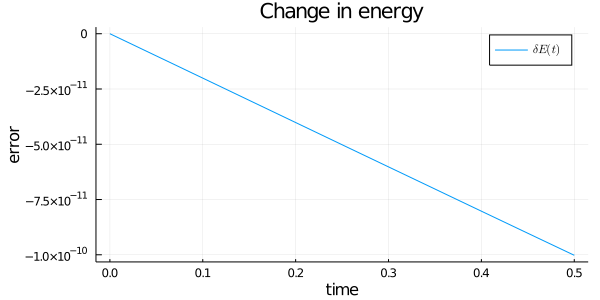

In [56]:
plot(t_eval, E .- E[begin], label=L"\delta E(t)", title="Change in energy", xlabel="time", ylabel="error")


### d) Solving the wave equation (Trapezium)

In this section, we write a program that uses the method of lines to evolve the first-order reduced waved equation.

As before, we consider the ODE system

$$
\begin{align*}
    \dot u &= \pi\\
    \dot\pi &= c^2\partial_x^2 u
\end{align*}
$$

With $\pi = \partial_t u$

The trapezium reule fot the wave equation yields a system of the form

$$
\begin{align*}
    {\bf u}_{n+1} - {\bf u}_n &= \int_{t_n}^{t_{n+1}} {\boldsymbol\pi}(t) dt \approx \frac{\Delta t}{2}(\boldsymbol\pi_{n+1} + \boldsymbol\pi_{n})\\
    {\boldsymbol \pi}_{n+1} - {\boldsymbol \pi}_n &= \int_{t_n}^{t_{n+1}} {\bf D}^2{\bf u}(t) dt \approx \frac{\Delta t}{2}{\bf D}^2({\bf u}_{n+1} + {\bf u}_{n})\\
\end{align*}
$$

Solving the system for ${\bf u}_{n+1}$, $\boldsymbol\pi_{n+1}$ yields

$$
    \boldsymbol\pi_{n+1} \approx \left[{\bf I} - \frac{(\Delta t)^2}{4}{\bf D}^2 \right]^{-1}\left[ \left({\bf I} + \frac{(\Delta t)^2}{4}{\bf D}^2\right)\boldsymbol\pi_{n} + \Delta t {\bf D}^2 {\bf u}_n\right]
$$

$$
    {\bf u}_{n+1} \approx \frac{\Delta t}{2} (\boldsymbol\pi_{n+1} + \boldsymbol\pi_{n}) + {\bf u}_n
$$

In [596]:
a, b, N = -2, 3, 100
xrange = range(a, b, length=N+1)
Δx = round(xrange.step.hi, digits=4)


Δt = 0.0005

u_n = f.(xrange)
π_n = -df.(xrange);

D = build_diff_matrix(xrange, Δx)
D2 = D ^ 2
D2[[begin, end], :] .= 0;

In [84]:
Δt = 5e-4
N = 201
a, b = -3, 3
xrange = range_chebyshev(a, b, length=N)
D = D_chebyshev(a, b, N)
D2 = D ^ 2
D2[[begin, end], :] .= 0;

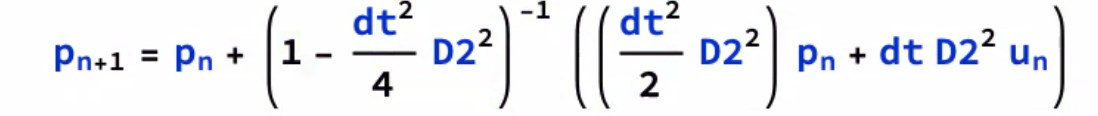

In [93]:
u_n = f.(xrange)
π_n = -df.(xrange);

T = 1

nits = Int(ceil(T / Δt) + 1)

U_hist = zeros(nits, 2, N + 1)

U_hist[begin, 1, :] = u_n
U_hist[begin, 2, :] = π_n;

M1 = I - Δt ^ 2 / 4 * D2
M1_inv = inv(M1)

for ti=2:nits
    #M2 = (I + Δt ^ 2 / 4 * D2) * π_n + Δt * D2 * u_n
    M2 = Δt ^2 / 2 * D2 * π_n + Δt * D2 * u_n

    π_n1 = M1_inv * M2 + π_n
    u_n1 = Δt / 2 * (π_n + π_n1) + u_n
    
    U_hist[ti, 1, :] = u_n1
    U_hist[ti, 2, :] = π_n1
    
    u_n = u_n1
    π_n = π_n1
end

In [94]:
nframes = 15
nskip = Int(floor(nits / nframes))

133

In [ ]:
Ax = b
x = A^-1 b

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
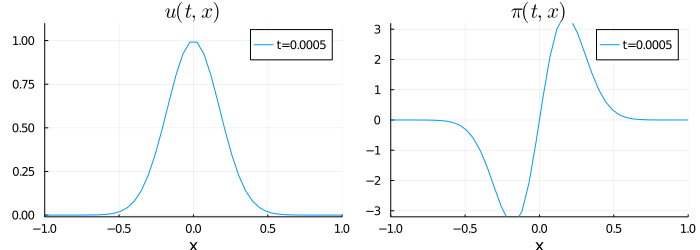

In [95]:
@gif for i in 1:nits
    time = round(Δt * i, digits=5)
    p1 = plot(xrange, U_hist[i, 1, :], label="t=$time", title=L"u(t, x)", xlabel="x", xlim=(-1,1), ylim=(-0.01, 1.1))
    p2 = plot(xrange, U_hist[i, 2, :], label="t=$time", title=L"\pi(t,x)", xlabel="x", xlim=(-1, 1), ylim=(-3.2, 3.2))
    plot(p1, p2, layout=(1, 2), size=(700, 250), suptitle="df")
end every nskip

### d.2) Plotting the energy

The total energy of the system at time $t$ is given by

$$
\begin{align*}
        E(t) = \frac{1}{2}\int \big[ (\partial_t u)^2 + c^2 (\partial_x u)^2 \big] dx
\end{align*}
$$

As with the previous exercise, we approximate the energy as follows:

$$
\begin{align*}
        E(t) &\approx \frac{1}{2}{\bf w}^T\left[ \boldsymbol{\pi}^2(t) + (\mathbb{D}{\bf u}(t))^2 \right]
\end{align*}
$$

Where ${\bf w}$ is a vector of weights necessary to compute the integral from -1 to 1 using the Clenshaw-Curtis quadrature rule which is given by

$$
    w_n = \begin{cases}
    1 / N ^2 & n \in \{0, N\} \\
    \frac{2}{N}\left(1 - \sum_{k=1}^{(N-1)/2}\frac{2\cos(2k\theta_n)}{4k^2-1}\right) & n\in\{1, \ldots, N-1\}
    \end{cases}
$$

In [96]:
t_eval = 0:Δt:T
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_numerical = U_hist[:, 1, :]
pi_numerical = U_hist[:, 2, :]
u_error = u_eval - u_numerical;

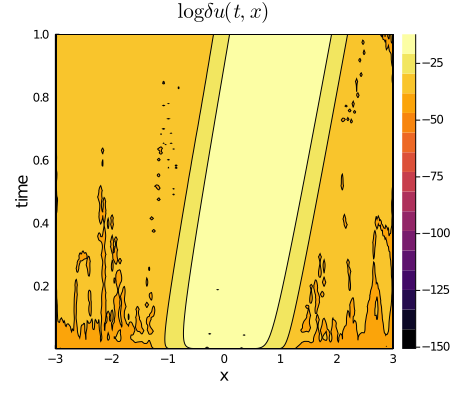

In [97]:
contourf(xrange, t_eval[2:end], log.(abs.(u_error))[2:end, :],
    xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400))

In [101]:
w_cc = clenshaw_curtis_weights(N, a, b);

In [102]:
@tensor begin
    Du[t, xi] := D[xi, x] * u_numerical[t, x]
end

@einsum E[t] := w_cc[x] * (pi_numerical[t, x] ^ 2 + (Du[t, x]) ^ 2) / 2;

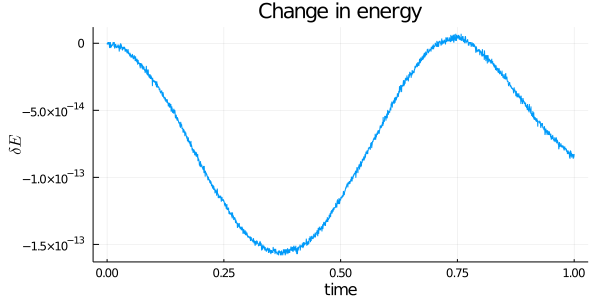

In [103]:
plot(0:Δt:T, E .- E[begin], label=nothing, title="Change in energy", xlabel="time", ylabel=L"\delta E")

## Question 4: Generating Random Numbers

In [99]:
U = rand(Float64, 10_000);

In [100]:
a, b = -2π, π
X = a .+ (b - a) * U;

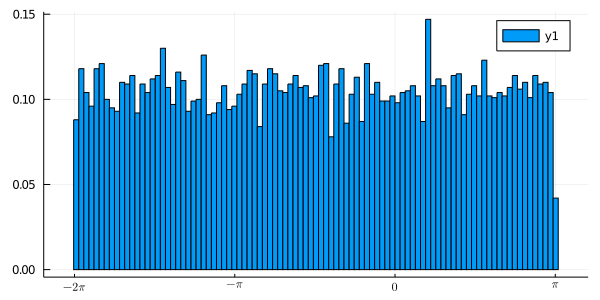

In [101]:
histogram(X, bins=100, norm=true)
plot!(xticks=(-2π:π:3π, [L"-2\pi", L"-\pi", L"0", L"\pi"]))

### 4.b) 

Uniform distribution over the union of the three intervals $[1, 2] \cup [3, 4] \cup [5, 6]$

The pdf for this distribution does not have an exact solution, therefore, for each $x_i$ sampled from our U(0, 1) distribution, we perform the bisection algorithm to find the inverse value $F_Y^{-1}(x_i)$

In [102]:
"""
Implement the bisection method to find the root
of a function, i.e., find x such that f(x) = 0.
To do so, the function requires a, b in R such that
(f(a) > 0 and f(b) < 0) or ((f(a) < 0 and f(b) > 0))
"""
function bisection(f, a, b; tol=1e-10)
    c = (a + b) / 2
    err = Inf
    
    while err > tol
        c = (a + b) / 2
        fc = f(c)
        
        if sign(fc) == sign(f(a))
            a = c
        else
            b = c
        end
        
        err = abs(fc)
    end
    return c
end


bisection

In [103]:
function F(y, a=1, b=2, c=3, d=4, e=5, f=6)
    I1 = a < y < b
    I2 = c < y < d
    I3 = e < y < f

    
    if y <= a
        Fy = 0
    elseif y < b
        Fy = (y - a) / 3(b - a)
    elseif y < d
        Fy = 1 / 3 + I2 * (y - c) / 3(d - c)
    elseif y < f
        Fy = 2 / 3 + I3 * (y - e) / 3(f - e)
    else
        return 1
    end
    
    return Fy
        
    
end

F (generic function with 7 methods)

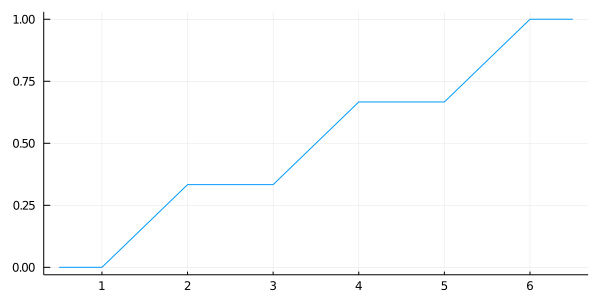

In [104]:
xrange = 0.5:0.05:6.5
plot(xrange, F.(xrange), legend=nothing)

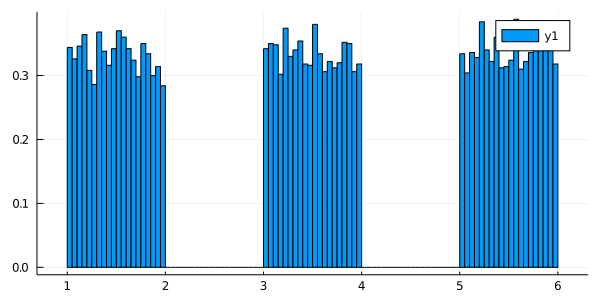

In [105]:
X = [bisection(y -> F(y) - x, 0, 7, tol=1e-10) for x in U]
histogram(X, bins=100, norm=true)

### 4.c) 

Gaussian distribution with a given mean value $\mu$ and variance $\sigma^2$ using the box-muller algorithm

The Box-Muller algorithm is as follows:

1. Generate pairs (x1,x2) of $U(-1,1)$ random variables
2. Descard each pair unless it satisfies $x^1 + x^2 \leq 1$
3. Evaluate the quantities

$$
    y_i = x_i\left(\frac{-2\log x_i}{r^2}\right) \ \forall i\in\{1,2\}
$$

It follows that $y_1\bot y_2$ and $\forall i. y_i\sim \mathcal{N}(0,1)$

In [106]:
N = 10_000
X2 = rand(Float64, (N, 2));

In [107]:
x1, x2 = X2[begin, :]

2-element Array{Float64,1}:
 0.7913323142083728
 0.6113663658875785

In [14]:
Y2 = zeros(N, 2)

n_obs = 1
for (x1, x2) in eachrow(X2)
    y1 = sqrt(-2log(x1)) * cos(2pi * x2)
    y2 = sqrt(-2log(x1)) * sin(2pi * x2)

    Y2[n_obs, 1] = y1
    Y2[n_obs, 2] = y2

    n_obs += 1
end

σ = 3
μ = 12.5

Y2 = Y2[begin:n_obs-1, :] * σ .+ μ;

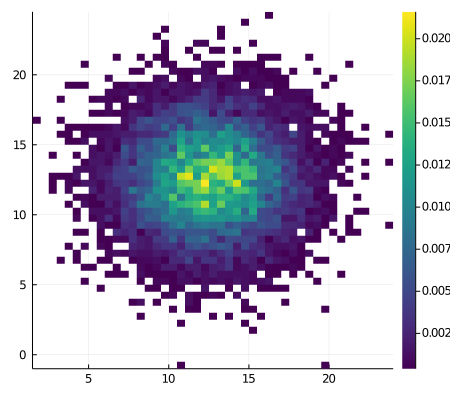

In [108]:
histogram2d(Y2[:, 1], Y2[:, 2], bins=90, size=(450, 400), color=:viridis, norm=true)

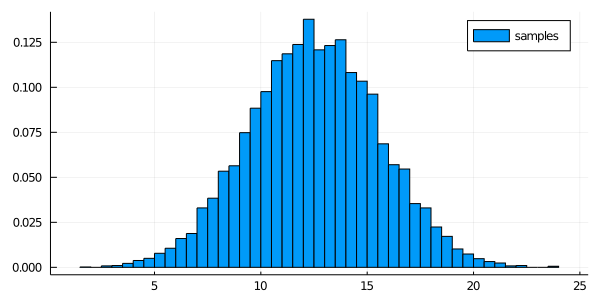

In [16]:
histogram(Y2[:, 1], norm=true, label="samples")

### 4.d)

Continuous distribution with probability density function


$$
    f(x \vert \lambda) = \lambda \exp(-\lambda x)
$$

To find the CDF $F(x)$, consider

$$
\begin{align*}
F(x) &= \int_0^x f(\hat x) d\hat x\\
     &= \int_0^x \lambda \exp(-\lambda \hat x) d\hat x\\
     &=  - \exp(-\lambda \hat x) \big\vert_{\hat x=0}^x \\
     &= - (\exp(-\lambda x) -  \exp(0))\\
     &= 1 - \exp(-\lambda x) 
\end{align*}
$$

Next, to find the inverse function, consider

$$
\begin{align*}
    y &= 1 - \exp(-\lambda x) \\
    y + 1 &= \exp(-\lambda x) \\
    \log(-y + 1) &= -\lambda x\\
    \frac{-1}{\lambda} \log(-y + 1) &= x
\end{align*}
$$

In [17]:
f(x, λ) = λ * exp(-λ * x)
Finv(y, λ) = -log(-y + 1) / λ;

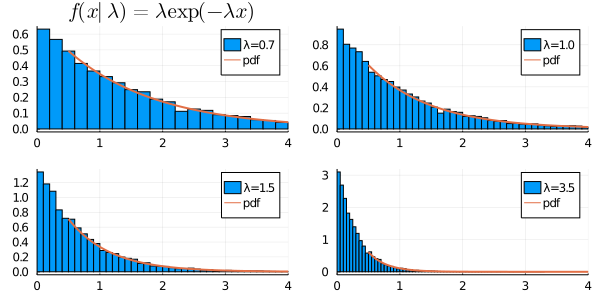

In [18]:
lambdas = [0.7, 1, 1.5, 3.5]
labels = ["λ=$λ" for λ in lambdas][new, :]
p = histogram(Finv.(U[:, new], lambdas[new, :]), layout=4, normed=true, xlim=(0, 4), labels=labels)
plot!(xrange, f.(xrange[:, new], lambdas[new, :]), linewidth=2, layout=4, label="pdf")

p.subplots[1].attr[:title] = L"f(x | \lambda) = \lambda \exp(-\lambda x)"
p

### 4.e) 

Continuous distribution with cumulative density function

$$
    F(x) = \frac{1}{6}(x^2 + x); x\in[0, 2]
$$

$$
    f(x) = \frac{d}{dx}F(x) = \frac{1}{6}(2x + 1)
$$

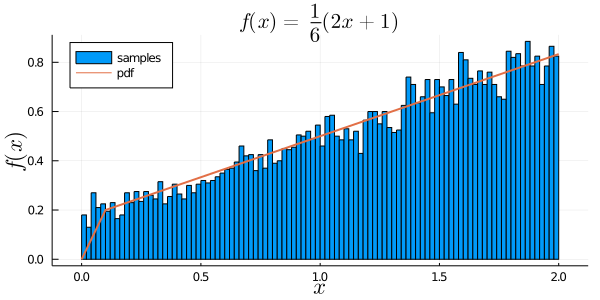

In [19]:
F(x) = (0 <= x <= 2) * (x ^ 2 + x) / 6 + (x > 2)
f(x) = (0 < x <= 2) * (2x + 1) / 6
X = [bisection(y -> F(y) - x, 0, 2) for x in U]
xrange = 0:0.1:2.01
histogram(X, bins=100, norm=true, label="samples")
plot!(xrange, f.(xrange), linewidth=2, label="pdf")
plot!(legend=:topleft, title=L"f(x) = \frac{1}{6}(2x + 1)", xlabel=L"x", ylabel=L"f(x)",
    xguidefontsize=15, yguidefontsize=15)

## Question 5: Importance sampling

Considering the integral

$$
    I = \int_0^1 x^3 (1 - x)^{1/2} dx = \frac{32}{315}
$$

which is the value of the Euler-Beta function

$$
    B(a, b) = \int_0^1 x^{a-1}(1-x)^{b-1} dx
$$

for $a=4$ and $b=3/2$

### 5.a) Montecarlo estimate

Construct a function to determine a Monte-Carlo estimate $I_U$ of $I$ using $N=1000$ uniform random variables in $[0, 1]$, and provide the absolute value of the estimate and the corresponding Mean Squared Error.

In [116]:
N = 1000
U = rand(Float64, N);

In [117]:
I_exact = 32 / 315

0.10158730158730159

In [118]:
g(x) = x ^ 3 * sqrt(1 - x)
I_approx = mean(g.(U))

0.09925628405654256

In [119]:
absolute_error = abs(round(I_exact - I_approx, digits=6))

0.002331

In [120]:
mse = var(g.(U)) / N

7.563130670048687e-6

### 5.b) Importance sampling

Determine a Monte-Carlo estimate of I using importance sampling. Choose N = 1000
random variables with a probability density function f(x) = 5x4, x ∈ [0, 1] as sampling
points. Provide the absolute error of the estimate. How much does this estimate
improves/deteriorates over the one obained in point (a) through simple sampling

$$
    \mathbb{E}[f] \approx \frac{1}{L}\sum_{l=1}^L \frac{p({\bf z}^{l})}{q({\bf z}^{l})} f(z^l)
$$

In [121]:
f(x) = (0 <= x <= 1) * 5x^4
zvals = U .^ (1/5);

In [128]:
mean(importance_weights) 

696.973837925471

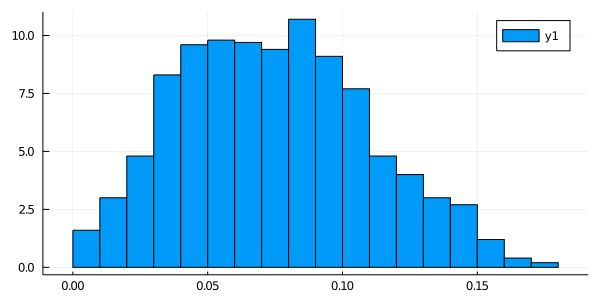

In [129]:
importance_weights = beta.(zvals, a=a, b=b) ./ f.(zvals)

histogram(importance_weights .* zvals, norm=true)

In [130]:
mean(importance_weights) - I_exact

0.001974135870712948

In [125]:
plot(xrange, beta.(xrange, a=a, b=b), label="Beta(x | a=$a, b=$b)")

LoadError: DomainError with -0.050000000000000044:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [126]:
32 / 315

0.10158730158730159

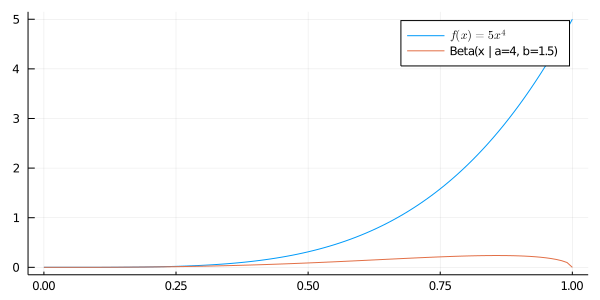

In [127]:
f(x) = (0 <= x <= 1) * 5x^4
beta(x; a, b) = x ^ (a - 1) * (1 - x) ^ (b - 1)
xrange = 0:0.01:1

a, b = 4, 3 / 2
plot(xrange, f.(xrange), label=L"f(x)=5x^4")
plot!(xrange, beta.(xrange, a=a, b=b), label="Beta(x | a=$a, b=$b)")